In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [22]:
# logs_base_path = "../../logs/"
logs_base_path = "/home/dc755/idiots/logs/"
logs_base_path = "logs/"
experiment_names = ["mnist-gd-grokking-2", "mnist-grokking-slower-2"]

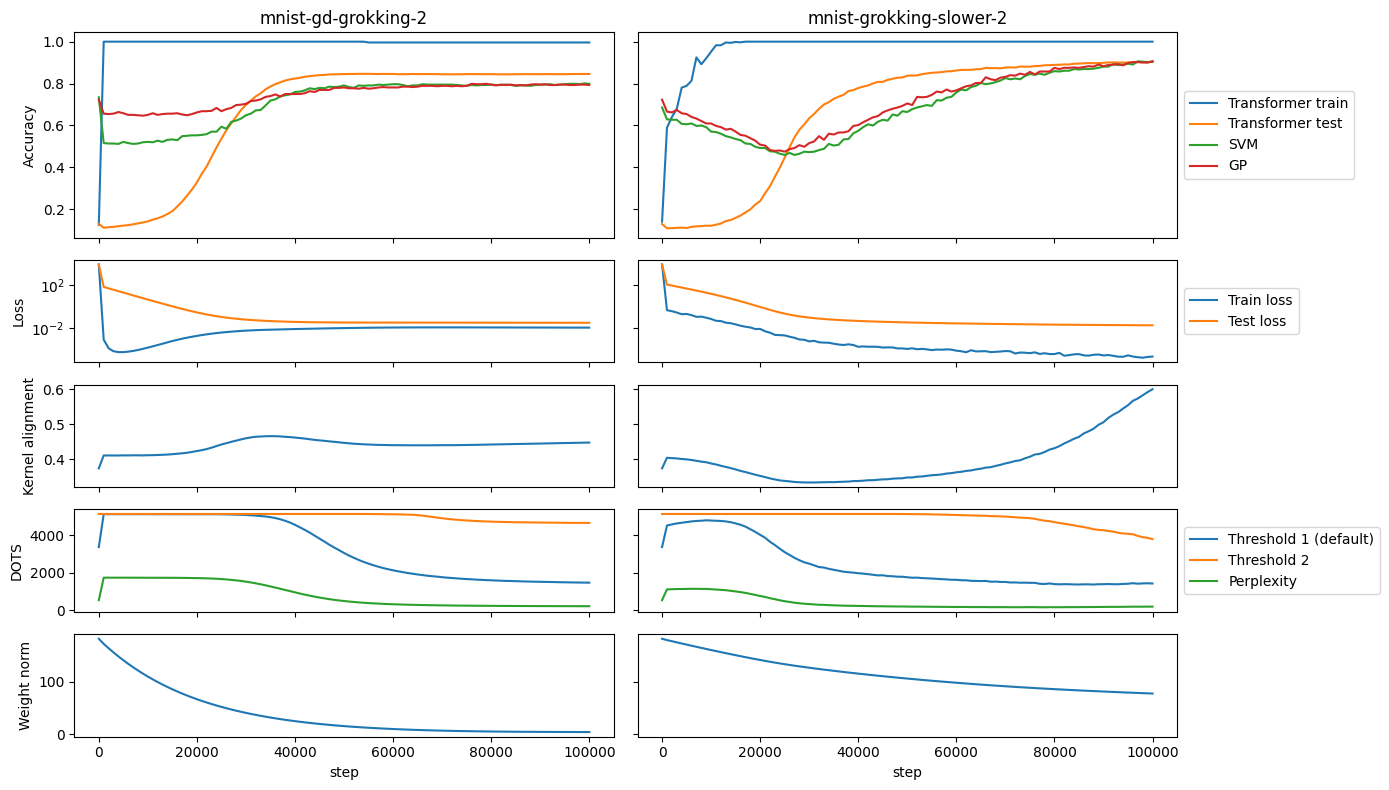

In [23]:
num_experiments = len(experiment_names)

fig, axs = plt.subplots(
    5,
    num_experiments,
    figsize=(2 + num_experiments * 6, 8),
    sharex="col",
    sharey="row",
    squeeze=False,
    gridspec_kw={"height_ratios": [2, 1, 1, 1, 1]},
)

for i, experiment_name in enumerate(experiment_names):
    checkpoint_dir = Path(logs_base_path, "results", f"{experiment_name}.json")

    with open(checkpoint_dir, "r") as json_file:
        df = pd.read_json(json_file)

    if not "step" in df.keys():
        df["step"] = df.index * 5

    ax1 = axs[0, i]
    ax2 = axs[1, i]
    ax3 = axs[2, i]
    ax4 = axs[3, i]
    ax5 = axs[4, i]

    sns.lineplot(data=df, x="step", y="training_acc", label="Transformer train", ax=ax1)
    sns.lineplot(data=df, x="step", y="test_acc", label="Transformer test", ax=ax1)
    sns.lineplot(data=df, x="step", y="svm_accuracy", label="SVM", ax=ax1)
    sns.lineplot(data=df, x="step", y="gp_accuracy", label="GP", ax=ax1)
    ax1.set(ylabel="Accuracy" if i == 0 else "", title=experiment_name)

    sns.lineplot(data=df, x="step", y="train_loss", label="Train loss", ax=ax2)
    sns.lineplot(data=df, x="step", y="test_loss", label="Test loss", ax=ax2)
    ax2.set(ylabel="Loss" if i == 0 else "", yscale="log")

    sns.lineplot(data=df, x="step", y="kernel_alignment", ax=ax3)
    ax3.set(ylabel="Kernel alignment" if i == 0 else "")

    sns.lineplot(data=df, x="step", y="dots", label="Threshold 1 (default)", ax=ax4)
    sns.lineplot(data=df, x="step", y="dots_2", label="Threshold 2", ax=ax4)
    sns.lineplot(data=df, x="step", y="dots_3", label="Perplexity", ax=ax4)
    ax4.set(ylabel="DOTS" if i == 0 else "")

    sns.lineplot(data=df, x="step", y="weight_norm", ax=ax5)
    ax5.set(ylabel="Weight norm" if i == 0 else "")

    for ax in axs[:, i]:
        if ax.get_legend() is not None:
            if i == len(experiment_names) - 1:
                ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
            else:
                ax.legend().set_visible(False)

fig.tight_layout()

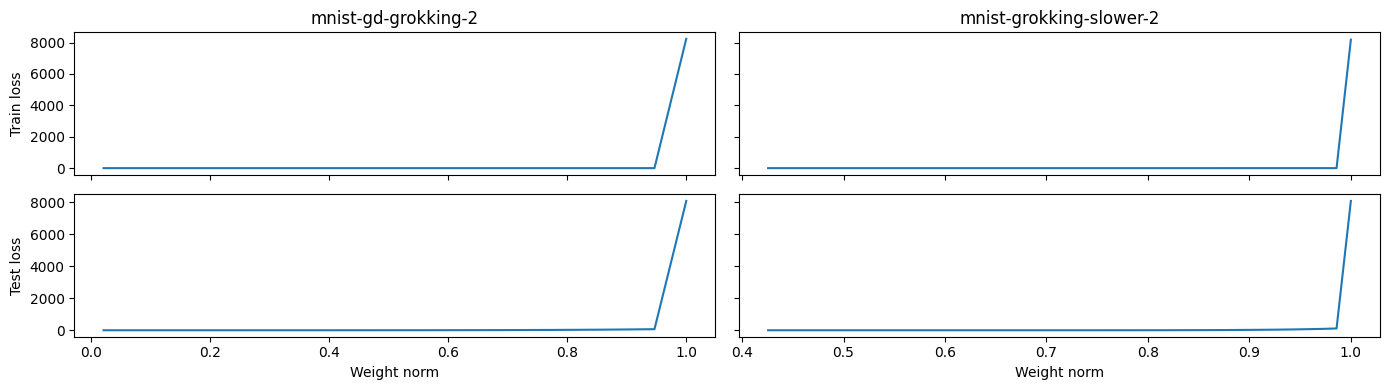

In [25]:
fig, axs = plt.subplots(
    2,
    num_experiments,
    figsize=(2 + num_experiments * 6, 4),
    sharex="col",
    sharey="row",
    squeeze=False,
)

for i, experiment_name in enumerate(experiment_names):
    checkpoint_dir = Path(logs_base_path, "results", f"{experiment_name}.json")

    with open(checkpoint_dir, "r") as json_file:
        df = pd.read_json(json_file)

    if not "step" in df.keys():
        df["step"] = df.index * 5

    ax1 = axs[0, i]
    ax2 = axs[1, i]

    sns.lineplot(data=df, x="relative_weight_norm", y="train_loss", ax=ax1)
    ax1.set(xlabel="Weight norm", ylabel="Train loss", title=experiment_name)

    sns.lineplot(data=df, x="relative_weight_norm", y="test_loss", ax=ax2)
    ax2.set(xlabel="Weight norm", ylabel="Test loss")

fig.tight_layout()
plt.show()

    